In [341]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlub-learning-to-count/train.txt
/kaggle/input/mlub-learning-to-count/test/test/test_composite000000426.png
/kaggle/input/mlub-learning-to-count/train/train/train_composite000012068.png


In [342]:
df_train = pd.read_csv('/kaggle/input/mlub-learning-to-count/train.txt',sep=' ',header=None)

# take only the first 200 images
df_train = df_train.head(500)

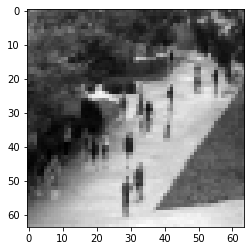

In [343]:
import imageio
from skimage import transform,io
import matplotlib.pyplot as plt
# read images and store into a np array

data_dir = '/kaggle/input/mlub-learning-to-count/train/'
im_size = 64
N = df_train.shape[0]
X = np.zeros((N, im_size,im_size))
y = np.zeros((N))
cont =0

for ind, item in df_train.iterrows():
    im       = imageio.imread(data_dir + item[0])/255.
    small_im = transform.resize(im, (im_size,im_size), mode='symmetric', preserve_range=True)
    X[cont, :,:] = small_im
    y[cont] = item[1]
    cont+=1

plt.imshow(small_im,cmap='gray')
plt.show()

In [344]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.33, random_state=66)

In [345]:
from sklearn.ensemble import RandomForestRegressor
# random forest model 
rfc = RandomForestRegressor()
rfc.fit(X_train.reshape((X_train.shape[0],-1)),y_train)
# predictions
rfc_predict = rfc.predict(X_val.reshape((X_val.shape[0],-1)))


5.306748705015324


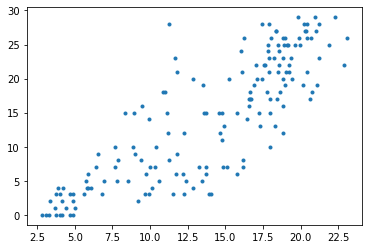

In [346]:
from sklearn.metrics import mean_squared_error
plt.plot(rfc_predict,y_val,'.')

print(np.sqrt(mean_squared_error(rfc_predict,y_val)))

In [347]:
import tensorflow as tf
from tensorflow import keras

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
history = {}

In [348]:
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

In [349]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

# create the model
model = keras.models.Sequential([
    DefaultConv2D(filters=32, kernel_size=3, input_shape=[64, 64, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.2),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.2),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.05)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=30, activation='softmax')
])


In [350]:
model.layers

In [351]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       7

In [352]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [353]:
history = model.fit(X_train, y_train, epochs=500,
                    validation_data=(X_val, y_val),verbose=1)

Epoch 1/500
11/11 [==============================] - 0s 29ms/step - loss: 7.4255 - accuracy: 0.0358 - val_loss: 5.1121 - val_accuracy: 0.0424
Epoch 2/500
11/11 [==============================] - 0s 7ms/step - loss: 4.3057 - accuracy: 0.0418 - val_loss: 3.6733 - val_accuracy: 0.0424
Epoch 3/500
11/11 [==============================] - 0s 7ms/step - loss: 3.5466 - accuracy: 0.0239 - val_loss: 3.4711 - val_accuracy: 0.0182
Epoch 4/500
11/11 [==============================] - 0s 7ms/step - loss: 3.4544 - accuracy: 0.0448 - val_loss: 3.4409 - val_accuracy: 0.0242
Epoch 5/500
11/11 [==============================] - 0s 7ms/step - loss: 3.4186 - accuracy: 0.0478 - val_loss: 3.4111 - val_accuracy: 0.0242
Epoch 6/500
11/11 [==============================] - 0s 7ms/step - loss: 3.4058 - accuracy: 0.0358 - val_loss: 3.4049 - val_accuracy: 0.0364
Epoch 7/500
11/11 [==============================] - 0s 7ms/step - loss: 3.3957 - accuracy: 0.0567 - val_loss: 3.4025 - val_accuracy: 0.0364
Epoch 8/500


Epoch 59/500
11/11 [==============================] - 0s 8ms/step - loss: 3.0335 - accuracy: 0.1075 - val_loss: 3.0122 - val_accuracy: 0.0848
Epoch 60/500
11/11 [==============================] - 0s 8ms/step - loss: 3.0389 - accuracy: 0.0776 - val_loss: 3.0010 - val_accuracy: 0.0970
Epoch 61/500
11/11 [==============================] - 0s 7ms/step - loss: 2.9825 - accuracy: 0.0955 - val_loss: 2.9155 - val_accuracy: 0.0970
Epoch 62/500
11/11 [==============================] - 0s 8ms/step - loss: 2.9691 - accuracy: 0.1104 - val_loss: 2.9477 - val_accuracy: 0.0788
Epoch 63/500
11/11 [==============================] - 0s 7ms/step - loss: 2.9142 - accuracy: 0.1313 - val_loss: 2.8703 - val_accuracy: 0.0788
Epoch 64/500
11/11 [==============================] - 0s 7ms/step - loss: 2.8758 - accuracy: 0.1164 - val_loss: 2.8020 - val_accuracy: 0.0848
Epoch 65/500
11/11 [==============================] - 0s 7ms/step - loss: 2.9242 - accuracy: 0.0985 - val_loss: 2.9620 - val_accuracy: 0.0727
Epoch 

11/11 [==============================] - 0s 7ms/step - loss: 2.5411 - accuracy: 0.1881 - val_loss: 2.5764 - val_accuracy: 0.1515
Epoch 117/500
11/11 [==============================] - 0s 7ms/step - loss: 2.4370 - accuracy: 0.2090 - val_loss: 2.5897 - val_accuracy: 0.1576
Epoch 118/500
11/11 [==============================] - 0s 7ms/step - loss: 2.5309 - accuracy: 0.2000 - val_loss: 2.6180 - val_accuracy: 0.1636
Epoch 119/500
11/11 [==============================] - 0s 7ms/step - loss: 2.4653 - accuracy: 0.1970 - val_loss: 2.5570 - val_accuracy: 0.1212
Epoch 120/500
11/11 [==============================] - 0s 7ms/step - loss: 2.3839 - accuracy: 0.2000 - val_loss: 2.5510 - val_accuracy: 0.1212
Epoch 121/500
11/11 [==============================] - 0s 10ms/step - loss: 2.4366 - accuracy: 0.1970 - val_loss: 2.5048 - val_accuracy: 0.1697
Epoch 122/500
11/11 [==============================] - 0s 11ms/step - loss: 2.5437 - accuracy: 0.2149 - val_loss: 2.5952 - val_accuracy: 0.1394
Epoch 123/5

11/11 [==============================] - 0s 8ms/step - loss: 2.2918 - accuracy: 0.2597 - val_loss: 2.5022 - val_accuracy: 0.1697
Epoch 174/500
11/11 [==============================] - 0s 7ms/step - loss: 2.3108 - accuracy: 0.2358 - val_loss: 2.5034 - val_accuracy: 0.1879
Epoch 175/500
11/11 [==============================] - 0s 7ms/step - loss: 2.3136 - accuracy: 0.2597 - val_loss: 2.4947 - val_accuracy: 0.1879
Epoch 176/500
11/11 [==============================] - 0s 7ms/step - loss: 2.2540 - accuracy: 0.2328 - val_loss: 2.4634 - val_accuracy: 0.1697
Epoch 177/500
11/11 [==============================] - 0s 7ms/step - loss: 2.2313 - accuracy: 0.2418 - val_loss: 2.4531 - val_accuracy: 0.1939
Epoch 178/500
11/11 [==============================] - 0s 7ms/step - loss: 2.2039 - accuracy: 0.2746 - val_loss: 2.4502 - val_accuracy: 0.1636
Epoch 179/500
11/11 [==============================] - 0s 7ms/step - loss: 2.2497 - accuracy: 0.1970 - val_loss: 2.4247 - val_accuracy: 0.1939
Epoch 180/500

11/11 [==============================] - 0s 8ms/step - loss: 2.1228 - accuracy: 0.2806 - val_loss: 2.4015 - val_accuracy: 0.1818
Epoch 231/500
11/11 [==============================] - 0s 7ms/step - loss: 2.0961 - accuracy: 0.3254 - val_loss: 2.4460 - val_accuracy: 0.1576
Epoch 232/500
11/11 [==============================] - 0s 8ms/step - loss: 2.0869 - accuracy: 0.3224 - val_loss: 2.4143 - val_accuracy: 0.1818
Epoch 233/500
11/11 [==============================] - 0s 7ms/step - loss: 2.1078 - accuracy: 0.2985 - val_loss: 2.4970 - val_accuracy: 0.1818
Epoch 234/500
11/11 [==============================] - 0s 7ms/step - loss: 2.1514 - accuracy: 0.3015 - val_loss: 2.5453 - val_accuracy: 0.1697
Epoch 235/500
11/11 [==============================] - 0s 7ms/step - loss: 2.1107 - accuracy: 0.3075 - val_loss: 2.4649 - val_accuracy: 0.1636
Epoch 236/500
11/11 [==============================] - 0s 7ms/step - loss: 2.1405 - accuracy: 0.2925 - val_loss: 2.4487 - val_accuracy: 0.1697
Epoch 237/500

11/11 [==============================] - 0s 8ms/step - loss: 1.9655 - accuracy: 0.3672 - val_loss: 2.5006 - val_accuracy: 0.1758
Epoch 288/500
11/11 [==============================] - 0s 7ms/step - loss: 2.0067 - accuracy: 0.3433 - val_loss: 2.4778 - val_accuracy: 0.2000
Epoch 289/500
11/11 [==============================] - 0s 7ms/step - loss: 1.9338 - accuracy: 0.3433 - val_loss: 2.4751 - val_accuracy: 0.1697
Epoch 290/500
11/11 [==============================] - 0s 7ms/step - loss: 1.9207 - accuracy: 0.3373 - val_loss: 2.5332 - val_accuracy: 0.1818
Epoch 291/500
11/11 [==============================] - 0s 7ms/step - loss: 1.9821 - accuracy: 0.3403 - val_loss: 2.4690 - val_accuracy: 0.2061
Epoch 292/500
11/11 [==============================] - 0s 7ms/step - loss: 1.9817 - accuracy: 0.3403 - val_loss: 2.6020 - val_accuracy: 0.1697
Epoch 293/500
11/11 [==============================] - 0s 7ms/step - loss: 1.9363 - accuracy: 0.3552 - val_loss: 2.5336 - val_accuracy: 0.1636
Epoch 294/500

11/11 [==============================] - 0s 7ms/step - loss: 1.9061 - accuracy: 0.3642 - val_loss: 2.5556 - val_accuracy: 0.2182
Epoch 345/500
11/11 [==============================] - 0s 7ms/step - loss: 1.9024 - accuracy: 0.3522 - val_loss: 2.5237 - val_accuracy: 0.1939
Epoch 346/500
11/11 [==============================] - 0s 7ms/step - loss: 1.8900 - accuracy: 0.3522 - val_loss: 2.5342 - val_accuracy: 0.1758
Epoch 347/500
11/11 [==============================] - 0s 7ms/step - loss: 1.9198 - accuracy: 0.3403 - val_loss: 2.5478 - val_accuracy: 0.1939
Epoch 348/500
11/11 [==============================] - 0s 7ms/step - loss: 1.8685 - accuracy: 0.3731 - val_loss: 2.5284 - val_accuracy: 0.1939
Epoch 349/500
11/11 [==============================] - 0s 7ms/step - loss: 1.8714 - accuracy: 0.4000 - val_loss: 2.5877 - val_accuracy: 0.1939
Epoch 350/500
11/11 [==============================] - 0s 7ms/step - loss: 1.9282 - accuracy: 0.3791 - val_loss: 2.5853 - val_accuracy: 0.1818
Epoch 351/500

11/11 [==============================] - 0s 7ms/step - loss: 1.7189 - accuracy: 0.4239 - val_loss: 2.6214 - val_accuracy: 0.1818
Epoch 402/500
11/11 [==============================] - 0s 7ms/step - loss: 1.8085 - accuracy: 0.4119 - val_loss: 2.5441 - val_accuracy: 0.1818
Epoch 403/500
11/11 [==============================] - 0s 8ms/step - loss: 1.7505 - accuracy: 0.4597 - val_loss: 2.5279 - val_accuracy: 0.2061
Epoch 404/500
11/11 [==============================] - 0s 7ms/step - loss: 1.7888 - accuracy: 0.4179 - val_loss: 2.5941 - val_accuracy: 0.1879
Epoch 405/500
11/11 [==============================] - 0s 7ms/step - loss: 1.8098 - accuracy: 0.3910 - val_loss: 2.6275 - val_accuracy: 0.1636
Epoch 406/500
11/11 [==============================] - 0s 7ms/step - loss: 1.7609 - accuracy: 0.4567 - val_loss: 2.5699 - val_accuracy: 0.2061
Epoch 407/500
11/11 [==============================] - 0s 7ms/step - loss: 1.7867 - accuracy: 0.4179 - val_loss: 2.6305 - val_accuracy: 0.1818
Epoch 408/500

11/11 [==============================] - 0s 7ms/step - loss: 1.7546 - accuracy: 0.4388 - val_loss: 2.6100 - val_accuracy: 0.2182
Epoch 459/500
11/11 [==============================] - 0s 7ms/step - loss: 1.7612 - accuracy: 0.3940 - val_loss: 2.6204 - val_accuracy: 0.2121
Epoch 460/500
11/11 [==============================] - 0s 7ms/step - loss: 1.8069 - accuracy: 0.4448 - val_loss: 2.6344 - val_accuracy: 0.2061
Epoch 461/500
11/11 [==============================] - 0s 7ms/step - loss: 1.7352 - accuracy: 0.4597 - val_loss: 2.5891 - val_accuracy: 0.2182
Epoch 462/500
11/11 [==============================] - 0s 7ms/step - loss: 1.8286 - accuracy: 0.4299 - val_loss: 2.6660 - val_accuracy: 0.1576
Epoch 463/500
11/11 [==============================] - 0s 8ms/step - loss: 1.7190 - accuracy: 0.4746 - val_loss: 2.6893 - val_accuracy: 0.1939
Epoch 464/500
11/11 [==============================] - 0s 8ms/step - loss: 1.7695 - accuracy: 0.4030 - val_loss: 2.6378 - val_accuracy: 0.2000
Epoch 465/500

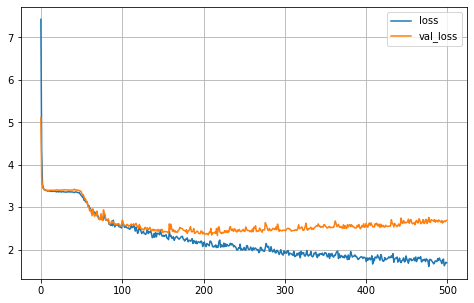

In [354]:
import pandas as pd

pd.DataFrame(history.history)[['loss','val_loss']].plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0.4, 0.8)
plt.show()

[29.  1. 20. 17. 24. 15.  9.  6.  7. 23. 19.  7. 21. 22. 13.  4. 15.  7.
 22. 25. 19. 26. 22. 21.  3.  9. 27. 27. 18. 28.  0.  8.  5. 20. 21.  5.
  6.  7.  3.  6.  3. 21. 23. 15.  4.  9. 29. 27.  4. 18. 19.  7.  2.  2.
  5. 11.  1.  8. 26. 26. 12. 20.  3.  3. 27. 26.  5. 27. 18. 28. 25.  3.
  3.  3.  1. 14.  5.  0.  5. 21. 10.  7. 10. 22. 28. 25. 10. 12. 25. 20.
  2. 28.  8.  7. 28. 15.  4.  6. 15.  3. 16.  7.  3. 18.  4. 22. 19. 21.
 24.  0.  3. 19. 15. 17. 16. 23. 23. 15.  3. 15. 12. 17. 26. 25. 12.  0.
  4. 13. 18.  0.  0. 21.  0. 24. 22. 15. 26. 23. 29. 25. 17.  7. 23.  0.
  4.  5. 13. 14. 25.  2. 20. 17. 25. 20.  8. 16. 28.  6. 17. 26. 15. 18.
 26. 10.  6.]
[27, 0, 25, 19, 26, 15, 8, 8, 8, 26, 25, 8, 29, 24, 14, 3, 18, 8, 19, 23, 14, 27, 29, 26, 2, 8, 19, 26, 13, 29, 0, 8, 7, 26, 18, 2, 6, 6, 3, 7, 3, 29, 20, 18, 3, 12, 26, 29, 3, 20, 18, 6, 3, 3, 6, 11, 0, 7, 28, 26, 13, 18, 3, 3, 29, 19, 6, 25, 13, 25, 18, 6, 3, 7, 0, 14, 6, 0, 6, 20, 8, 6, 11, 29, 26, 23, 14, 8, 25, 20, 1, 29, 

3.251107037563816

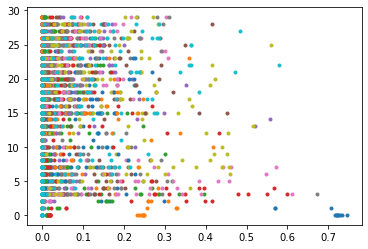

In [355]:
y_model1 = model.predict(X_val)
plt.plot(y_model1,y_val,'.')
print(y_val)
y_model_output = []
for i in y_model1:
    y_model_output.append(np.argmax(i))
print(y_model_output)
np.sqrt(mean_squared_error(y_model_output,y_val))

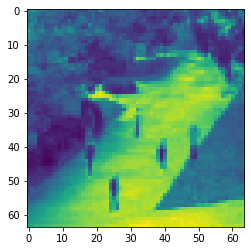

In [356]:
## evaluate test and generate submission
test_dir = '/kaggle/input/mlub-learning-to-count/test/test/'
im_size = 64
N = 500
X_test = np.zeros((N, im_size,im_size))
cont =0

for x in range(500):
    im       = imageio.imread(test_dir + 'test_composite'+str(x).zfill(9) + '.png')/255.
    small_im = transform.resize(im, (im_size,im_size), mode='symmetric', preserve_range=True)
    X_test[cont, :,:] = small_im
    cont+=1
    
plt.imshow(small_im)
plt.show()

In [357]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [358]:
# create the file to make the sumbission

y_test = model.predict(X_test)
print(y_test)
y_test = [np.argmax(x) for x in y_test]

df_output = pd.DataFrame(y_test)
df_output.index.name = 'index'
df_output.columns = ['prediction']
df_output.to_csv('output.csv')


[[5.5643421e-16 5.1522232e-17 9.1060892e-17 ... 3.5557810e-02
  5.4552507e-02 3.7480986e-01]
 [3.8675840e-09 2.2146003e-09 4.7350848e-09 ... 9.9219766e-04
  8.6863164e-04 9.3437248e-04]
 [5.7599824e-08 2.9486694e-08 9.2487390e-08 ... 7.7438564e-04
  9.8146242e-04 7.6697639e-04]
 ...
 [2.3700517e-01 3.0496973e-01 1.6933829e-01 ... 1.8669604e-24
  2.5187855e-24 2.4324466e-27]
 [2.1128954e-11 1.0691654e-11 1.4945777e-10 ... 2.6728034e-03
  1.2291889e-03 4.0955475e-04]
 [8.4279076e-05 1.2432263e-04 2.7854994e-03 ... 2.9040800e-13
  6.0461584e-14 1.8704177e-17]]


In [359]:
print(y_test)

[29, 18, 18, 26, 25, 15, 25, 26, 0, 13, 18, 2, 3, 18, 17, 6, 10, 0, 25, 17, 3, 18, 25, 10, 14, 0, 5, 3, 8, 1, 8, 25, 10, 20, 29, 0, 18, 8, 3, 7, 18, 18, 8, 29, 18, 18, 18, 28, 3, 18, 29, 0, 26, 10, 0, 27, 8, 11, 18, 26, 26, 14, 14, 1, 3, 15, 0, 7, 11, 12, 25, 3, 0, 13, 28, 8, 8, 18, 13, 26, 6, 21, 27, 19, 1, 27, 18, 27, 19, 21, 25, 18, 26, 0, 29, 29, 19, 18, 0, 3, 10, 8, 29, 25, 23, 8, 12, 26, 15, 8, 23, 20, 29, 28, 28, 10, 8, 3, 6, 15, 25, 6, 6, 25, 19, 13, 7, 18, 3, 13, 23, 19, 3, 13, 21, 18, 6, 18, 10, 3, 14, 3, 13, 14, 0, 11, 20, 18, 19, 15, 3, 19, 13, 29, 7, 0, 18, 17, 29, 26, 0, 11, 13, 18, 18, 18, 8, 18, 25, 6, 13, 10, 19, 15, 8, 12, 28, 18, 3, 29, 0, 26, 6, 27, 7, 8, 29, 26, 29, 12, 21, 7, 29, 24, 19, 14, 18, 21, 8, 29, 29, 10, 29, 10, 22, 24, 13, 26, 18, 2, 25, 25, 12, 29, 29, 14, 6, 6, 18, 0, 13, 0, 25, 25, 29, 5, 27, 13, 6, 0, 25, 26, 8, 29, 13, 8, 18, 29, 8, 0, 8, 17, 5, 3, 7, 29, 6, 13, 28, 11, 7, 8, 11, 0, 12, 8, 26, 1, 29, 8, 26, 0, 25, 29, 3, 8, 0, 7, 10, 3, 7, 3, 14, 2

In [360]:
'''plt.imshow(X_test[3])
plt.show()'''

'plt.imshow(X_test[3])\nplt.show()'